<a href="https://colab.research.google.com/github/TheHouseOfVermeulens/wernervermeulen.github.io/blob/master/Feature_Engineering_Kickstarter_projects%5Bpractice%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Through hands-on feature engineering applications I have:

    Develop a baseline model for comparing performance on models with more features
    Encode categorical features so the model can make better use of the information
    Generate new features to provide more information for the model
    Select features to reduce overfitting and increase prediction speed


Building Kickstarter prediction models: 

What we can do here is predict if a Kickstarter project will succeed. We get the outcome from the state column. To predict the outcome we can use features such as category, currency, funding goal, country, and when it was launched.

The first few rows of the Kickstarter projects data looks like this:

In [0]:
import pandas as pd
ks = pd.read_csv('../input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])
ks.head(10)



```
 	ID 	name 	category 	main_category 	currency 	deadline 	goal 	launched 	pledged 	state 	backers 	country 	usd pledged 	usd_pledged_real 	usd_goal_real
0 	1000002330 	The Songs of Adelaide & Abullah 	Poetry 	Publishing 	GBP 	2015-10-09 	1000.0 	2015-08-11 12:12:28 	0.00 	failed 	0 	GB 	0.00 	0.00 	1533.95
1 	1000003930 	Greeting From Earth: ZGAC Arts Capsule For ET 	Narrative Film 	Film & Video 	USD 	2017-11-01 	30000.0 	2017-09-02 04:43:57 	2421.00 	failed 	15 	US 	100.00 	2421.00 	30000.00
2 	1000004038 	Where is Hank? 	Narrative Film 	Film & Video 	USD 	2013-02-26 	45000.0 	2013-01-12 00:20:50 	220.00 	failed 	3 	US 	220.00 	220.00 	45000.00
3 	1000007540 	ToshiCapital Rekordz Needs Help to Complete Album 	Music 	Music 	USD 	2012-04-16 	5000.0 	2012-03-17 03:24:11 	1.00 	failed 	1 	US 	1.00 	1.00 	5000.00
4 	1000011046 	Community Film Project: The Art of Neighborhoo... 	Film & Video 	Film & Video 	USD 	2015-08-29 	19500.0 	2015-07-04 08:35:03 	1283.00 	canceled 	14 	US 	1283.00 	1283.00 	19500.00
5 	1000014025 	Monarch Espresso Bar 	Restaurants 	Food 	USD 	2016-04-01 	50000.0 	2016-02-26 13:38:27 	52375.00 	successful 	224 	US 	52375.00 	52375.00 	50000.00
6 	1000023410 	Support Solar Roasted Coffee & Green Energy! ... 	Food 	Food 	USD 	2014-12-21 	1000.0 	2014-12-01 18:30:44 	1205.00 	successful 	16 	US 	1205.00 	1205.00 	1000.00
7 	1000030581 	Chaser Strips. Our Strips make Shots their B*tch! 	Drinks 	Food 	USD 	2016-03-17 	25000.0 	2016-02-01 20:05:12 	453.00 	failed 	40 	US 	453.00 	453.00 	25000.00
8 	1000034518 	SPIN - Premium Retractable In-Ear Headphones w... 	Product Design 	Design 	USD 	2014-05-29 	125000.0 	2014-04-24 18:14:43 	8233.00 	canceled 	58 	US 	8233.00 	8233.00 	125000.00
9 	100004195 	STUDIO IN THE SKY - A Documentary Feature Film... 	Documentary 	Film & Video 	USD 	2014-08-10 	65000.0 	2014-07-11 21:55:48 	6240.57 	canceled 	43 	US 	6240.57 	6240.57 	65000.00
```



Preparing target column

First I'll look at project states and convert the column into something we can use as targets in a model.

In [0]:
pd.unique(ks.state)

Out[2]
```
array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)
```



We have six states, how many records of each?

In [0]:
ks.groupby('state')['ID'].count()

Out[3]

```
state
canceled       38779
failed        197719
live            2799
successful    133956
suspended       1846
undefined       3562
Name: ID, dtype: int64
```






Data cleaning isn't the current focus, so we'll simplify this example by:

    Dropping projects that are "live"
    Counting "successful" states as outcome = 1
    Combining every other state as outcome = 0



In [0]:
# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))


Converting timestamps

I convert the launched feature into categorical features we can use in a model. Since I loaded in the columns as timestamp data, I access date and time values through the .dt attribute on the timestamp column.


In [0]:
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)


Prepping categorical variables

Now for the categorical variables -- category, currency, and country -- I'll need to convert them into integers so our model can use the data. For this I'll use scikit-learn's LabelEncoder. This assigns an integer to each value of the categorical feature and replaces those values with the integers.


In [0]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = ks[cat_features].apply(encoder.fit_transform)
encoded.head(10)

Out[4]
```
   category currency country
0 	108 	5   	9
1 	93 	13 	  22
2 	93 	13 	  22
3 	90 	13 	  22
4 	55 	13 	  22
5 	123 	13 	22
6 	58 	13 	  22
7 	41 	13 	  22
8 	113 	13 	22
9 	39 	13 	  22
```


I collect all the features we'll use in a new dataframe and use that to train a model.

In [0]:
# Since ks and encoded have the same index and I can easily join them
data = ks[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded)
data.head()

Out[5]

In [0]:
 	   goal 	hour 	 day 	month 	 year 	outcome 	category 	currency 	country
0 	1000.0 	 12 	  11 	   8 	   2015 	  0 	      108 	    5 	       9
1 	30000.0 	4 	   2 	   9 	   2017 	  0 	       93 	   13 	      22
2 	45000.0 	0 	  12 	   1 	   2013 	  0 	       93 	   13 	      22
3 	5000.0 	  3 	  17 	   3 	   2012 	  0 	       90 	   13 	      22
4 	19500.0 	8 	   4 	   7     2015 	  0 	       55 	   13 	      22


Creating training, validation, and test splits

We need to create data sets for training, validation, and testing. We'll use a fairly simple approach and split the data using slices. We'll use 10% of the data as a validation set, 10% for testing, and the other 80% for training.


In [0]:
valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

train = data[:-2 * valid_size]
valid = data[-2 * valid_size:-valid_size]
test = data[-valid_size:]


In general I am careful that each data set has the same proportion of target classes. I print out the fraction of successful outcomes for each of our datasets.

In [0]:
for each in [train, valid, test]:
    print(f"Outcome fraction = {each.outcome.mean():.4f}")


Out[6]

In [0]:

Outcome fraction = 0.3570
Outcome fraction = 0.3539
Outcome fraction = 0.3542

This looks good, each set is around 35% true outcomes likely because the data was well randomized beforehand. A good way to do this automatically is with sklearn.model_selection.StratifiedShuffleSplit but I don't need to use it here.


Training a LightGBM model

For this course we'll be using a LightGBM model. This is a tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train. We won't do hyperparameter optimization because that isn't the goal of this course. So, our models won't be the absolute best performance you can get. But you'll still see model performance improve as we do feature engineering.


In [0]:
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)


Making predictions & evaluating the model

Finally, let's make predictions on the test set with the model and see how well it performs. An important thing to remember is that you can overfit to the validation data. This is why we need a test set that the model never sees until the final evaluation.


In [0]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.747615303004287

Looks good from here! #Run and learn

Now that I've built a baseline model, I am ready to improve it with some clever ways to convert categorical variables into numerical features. These encodings will be learned from the data itself. The most basic encodings are one-hot encoding and label encoding. 

Here, I use count encoding, target encoding (and variations), and singular value decomposition.

# Count Encoding

Count encoding replaces each categorical value with the number of times it appears in the dataset. For example, if the value "GB" occured 10 times in the country feature, then each "GB" would be replaced with the number 10.

In [0]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix("_count"))

# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Out[10]
Training model!
Validation AUC score: 0.7486

Adding the count encoding features increase the validation score from 0.7467 to 0.7486, only a slight improvement.


# Target Encoding

Target encoding replaces a categorical value with the average value of the target for that value of the feature. For example, given the country value "CA", you'd calculate the average outcome for all the rows with country == 'CA', around 0.28. This is often blended with the target probability over the entire dataset to reduce the variance of values with few occurences.

This technique uses the targets to create new features. So including the validation or test data in the target encodings would be a form of target leakage. Instead, I should learn the target encodings from the training dataset only and apply it to the other datasets.

The category_encoders package provides TargetEncoder for target encoding. The implementation is similar to CountEncoder.


In [0]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']

# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)

# Fit the encoder using the categorical features and target
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

train.head()
bst = train_model(train, valid)

Out[11] Training model!
Validation AUC score: 0.7491

The validation score is higher again, from 0.7467 to 0.7491.


# CatBoost Encoding

Finally, I look at CatBoost encoding. This is similar to target encoding in that it's based on the target probablity for a given value. However with CatBoost, for each row, the target probability is calculated only from the rows before it.


In [0]:
cat_features = ['category', 'currency', 'country']
target_enc = ce.CatBoostEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)
target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

bst = train_model(train, valid)

Out[12]
Training model!
Validation AUC score: 0.7492

Does slightly better than TargetEncoding 

# Creating new features


Creating new features from the raw data is one of the best ways to improve a model. For example, I can calculate the number of total projects in the last week and the duration of the fundraising period. The features I create are different for every dataset, so it takes a bit of creativity and experimentation.  


Interactions

One of the easiest ways to create new features is by combining categorical variables. For example, if one record has the country "CA" and category "Music", I can create a new value "CA_Music". This is a new categorical feature that can provide information about correlations between categorical variables. This type of feature is typically called an interaction. In general, I build interaction features from all pairs of categorical features. I can make interactions from three or more features as well, but I tend to get diminishing returns.

Pandas lets us simply add string columns together like normal Python strings.


In [0]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(10))

In [0]:
0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object

Then, label encode the interaction feature and add it to my data.

In [0]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

In [0]:
 	   goal 	hour 	day 	month 	year 	outcome 	category 	currency 	country 	category_country
0 	1000.0 	 12 	11 	    8 	  2015   	0 	       108 	     5 	       9 	       1900
1 	30000.0 	4 	 2 	    9 	  2017 	  0 	        93 	    13 	      22 	       1630
2 	45000.0 	0 	12 	    1 	  2013 	  0 	        93 	    13 	      22 	       1630
3 	5000.0 	  3 	17 	    3 	  2012 	  0 	        90 	    13 	      22 	       1595
4 	19500.0 	8 	 4 	    7 	  2015 	  0 	        55 	    13 	      22 	        979


Number of projects in the last week

First up I count the number of projects launched in the preceeding week for each record. I use the .rolling method on a series with the "launched" column as the index. I create the series, using ks.launched as the index and ks.index as the values, then sort the times. Using a time series as the index allows me to define the rolling window size in terms of hours, days, weeks, etc.


In [0]:
# First, create a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

In [0]:
launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

With a timeseries index, I can use .rolling to select time periods as the window. For example launched.rolling('7d') creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so when I want to count all the previous projects but not the current one, I'll have to subtract 1. Plotting the results to make sure it looks right, helps

In [0]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [0]:
launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64

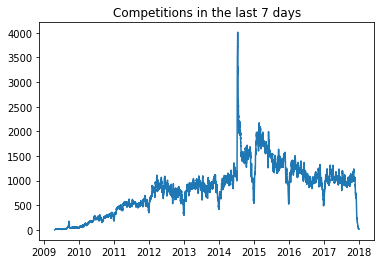

Now that we have the counts, we need to adjust the index so we can join it with the other training data.

In [0]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)


In [0]:
count_7_days.head(10)

In [0]:
0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

Now I join the new feature with the other data again using .join since we've matched the index.

In [0]:
baseline_data.join(count_7_days).head(10)


In [0]:
 	   goal 	hour 	day 	month 	year 	outcome 	category 	currency 	country 	count_7_days
0 	1000.0 	 12 	11 	    8 	  2015 	  0 	      108 	     5 	       9 	     1409.0
1 	30000.0 	4 	2 	    9 	  2017 	  0 	       93 	    13 	      22 	      957.0
2 	45000.0 	0 	12 	    1 	  2013 	  0 	       93 	    13 	      22 	      739.0
3 	5000.0 	  3 	17 	    3 	  2012 	  0 	       90 	    13 	      22 	      907.0
4 	19500.0 	8 	4 	    7 	  2015 	  0 	       55 	    13 	      22 	     1429.0
5 	50000.0  13 	26 	    2 	  2016 	  1 	      123 	    13      	22 	     1284.0
6 	1000.0 	 18 	1 	   12 	  2014 	  1 	       58 	    13 	      22 	     1119.0
7 	25000.0  20 	1 	    2 	  2016 	  0 	       41 	    13      	22 	     1391.0
8 	125000.0 18 	24 	    4 	  2014 	  0 	      113 	    13      	22 	     1043.0
9 	65000.0  21 	11 	    7 	  2014 	  0 	       39 	    13 	      22 	     3199.0


Time since the last project in the same category

Do projects in the same category compete for donors? If an entrepreneur is trying to fund a video game and another game project was just launched, the entrepreneurs might not get as much money. I can capture this by calculating the time since the last launch project in the same category.

A handy method for performing operations within groups is to use .groupby then .transform. The .transform method takes a function then passes a series or dataframe to that function for each group. This returns a dataframe with the same indices as the original dataframe. In this case, I perform a groupby on "category" and use transform to calculate the time differences for each category.


In [0]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

In [0]:
 	     launched
94579 	NaN
319002 	NaN
247913 	NaN
48147 	NaN
75397 	NaN
2842 	  0.000000
273779 	NaN
169268 	NaN
322000 	NaN
138572 	NaN
325391 	NaN
122662 	137.130833
213711 	NaN
345606 	145.941111
235255 	NaN
98954 	344715.626944
342226 	NaN
275091 	NaN
284115 	NaN
32898 	NaN

I get NaNs here for projects that are the first in their category. I'll have to fill those in with the mean or median. I also need to reset the index so I can join it with the other data.

In [0]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

In [0]:
 	   launched
0 	18.606111
1 	5.592778
2 	1.313611
3 	0.635000
4 	16.661389
5 	2.629722
6 	0.367500
7 	12.286111
8 	14.243611
9 	0.174722
10 	1.372222
11 	8.524444
12 	0.015833
13 	9.884444
14 	1.725556
15 	3.806111
16 	2.654167
17 	26.531667
18 	12.273611
19 	9.288889


Transforming numerical features

The distribution of the values in "goal" shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are normally distributed, so it might help to transform the goal values. Common choices for this are the square root and natural logarithm. These transformations can also help constrain outliers.

Here I'll transform the goal feature using the square root and log functions, then fit a model to see if it helps


In [0]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');


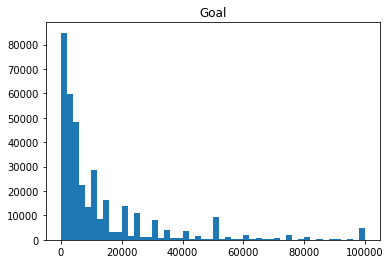)

In [0]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

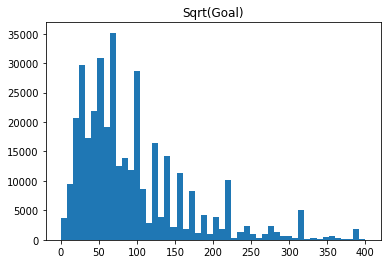

In [0]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

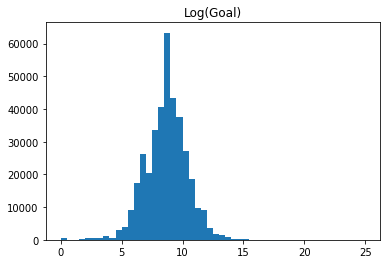![alt text](https://)

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.

# Feature selection

First up #Note here: Often I have seen hundreds and thousands of features after various encodings and feature generation. This can lead to two problems. First, the more features I have, the more likely I am to overfit to the training and validation sets. This will cause my model to perform worse at generalizing to new data.

Secondly, the more features I have, the longer it will take to train my model and optimize hyperparameters. Also, when building user-facing products, I want to make inference as fast as possible. Using fewer features can speed up inference at the cost of predictive performance.

To help with these issues, I want to use feature selection techniques to keep the most informative features for your model.

# Univariate Feature Selection

The simplest and fastest methods are based on univariate statistical tests. For each feature, measure how strongly the target depends on the feature using a statistical test like 𝜒2

or ANOVA.

From the scikit-learn feature selection module, feature_selection.SelectKBest returns the K best features given some scoring function. For our classification problem, the module provides three different scoring functions: 𝜒2

, ANOVA F-value, and the mutual information score. The F-value measures the linear dependency between the feature variable and the target. This means the score might underestimate the relation between a feature and the target if the relationship is nonlinear. The mutual information score is nonparametric and so can capture nonlinear relationships.

With SelectKBest, we define the number of features to keep, based on the score from the scoring function. Using .fit_transform(features, target) we get back an array with only the selected features.

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline_data.columns.drop('outcome')

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(baseline_data[feature_cols], baseline_data['outcome'])
X_new

In [0]:
array([[2015.,    5.,    9.,   18., 1409.],
       [2017.,   13.,   22.,   31.,  957.],
       [2013.,   13.,   22.,   31.,  739.],
       ...,
       [2010.,   13.,   22.,   31.,  238.],
       [2016.,   13.,   22.,   31., 1100.],
       [2011.,   13.,   22.,   31.,  542.]])

# Note here:
The statistical tests are calculated using all of the data. This means information from the validation and test sets could influence the features we keep, introducing a source of leakage. This means I should select features using only a training set.

In [0]:
feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

In [0]:
array([[2.015e+03, 5.000e+00, 9.000e+00, 1.800e+01, 1.409e+03],
       [2.017e+03, 1.300e+01, 2.200e+01, 3.100e+01, 9.570e+02],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 7.390e+02],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01, 3.100e+01, 5.150e+02],
       [2.015e+03, 1.000e+00, 3.000e+00, 2.000e+00, 1.306e+03],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 1.084e+03]])

# Note here:
The selected features are different than when I used the entire dataset. Now I have our selected features, but it's only the feature values for the training set. To drop the rejected features from the validation and test sets, I need to figure out which columns in the dataset were kept with SelectKBest. To do this, I can use .inverse_transform to get back an array with the shape of the original data.

In [0]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

In [0]:
 	  goal 	hour 	day 	month 	year 	category 	currency 	country 	category_currency 	category_country 	currency_country 	count_7_days 	time_since_last_project
0 	0.0 	0.0 	0.0 	0.0 	2015.0 	0.0 	        5.0 	9.0 	        0.0 	                0.0 	            18.0 	1409.0 	0.0
1 	0.0 	0.0 	0.0 	0.0 	2017.0 	0.0 	       13.0 	22.0 	        0.0 	                0.0             	31.0 	957.0 	0.0
2 	0.0 	0.0 	0.0 	0.0 	2013.0 	0.0 	       13.0 	22.0 	        0.0 	                0.0             	31.0 	739.0 	0.0
3 	0.0 	0.0 	0.0 	0.0 	2012.0 	0.0 	       13.0 	22.0 	        0.0                 	0.0              	31.0 	907.0 	0.0
4 	0.0 	0.0 	0.0 	0.0 	2015.0 	0.0 	       13.0 	22.0 	        0.0 	                0.0 	            31.0 	1429.0 	0.0

This returns a DataFrame with the same index and columns as the training set, but all the dropped columns are filled with zeros. I can find the selected columns by choosing features where the variance is non-zero.

In [0]:
 Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
valid[selected_columns].head()

In [0]:
 	      year 	currency 	country 	currency_country 	count_7_days
302896 	2015 	13 	        22 	          31 	              1534.0
302897 	2013 	13 	        22 	          31 	               625.0
302898 	2014 	5 	         9 	          18 	               851.0
302899 	2014 	13 	        22 	          31 	              1973.0
302900 	2014 	5 	         9 	          18 	              2163.0


# L1 regularization

Univariate methods consider only one feature at a time when making a selection decision. Instead, I can make our selection using all of the features by including them in a linear model with L1 regularization. This type of regularization (sometimes called Lasso) penalizes the absolute magnitude of the coefficients, as compared to L2 (Ridge) regression which penalizes the square of the coefficients.

As the strength of regularization is increased, features which are less important for predicting the target are set to 0. This allows us to perform feature selection by adjusting the regularization parameter. I choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

For regression problems I can use sklearn.linear_model.Lasso, or sklearn.linear_model.LogisticRegression for classification. These can be used along with sklearn.feature_selection.SelectFromModel to select the non-zero coefficients. Otherwise, the code is similar to the univariate tests.


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

In [0]:


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

array([[1.000e+03, 1.200e+01, 1.100e+01, ..., 1.900e+03, 1.800e+01,
        1.409e+03],
       [3.000e+04, 4.000e+00, 2.000e+00, ..., 1.630e+03, 3.100e+01,
        9.570e+02],
       [4.500e+04, 0.000e+00, 1.200e+01, ..., 1.630e+03, 3.100e+01,
        7.390e+02],
       ...,
       [2.500e+03, 0.000e+00, 3.000e+00, ..., 1.830e+03, 3.100e+01,
        5.150e+02],
       [2.600e+03, 2.100e+01, 2.300e+01, ..., 1.036e+03, 2.000e+00,
        1.306e+03],
       [2.000e+04, 1.600e+01, 4.000e+00, ..., 9.200e+02, 3.100e+01,
        1.084e+03]])



Similar to the univariate tests, I get back an array with the selected features. Again, I will want to convert these to a DataFrame so I can get the selected columns.

In [0]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In this case with the L1 parameter C=1, by dropping the time_since_last_project column.

In general, feature selection with L1 regularization is more powerful the univariate tests, but it can also be very slow when I have a lot of data and a lot of features. Univariate tests will be much faster on large datasets, but also will likely perform worse.